# Topic Modelling
Felix Zaussinger | 08.01.2021

## Core Analysis Goal(s)
1. Explore simple topic models based on the sparse **group-term matrix** format
2. Extract some insights. See which steps in the pre-processing chain should be revisited to improve interpretability
3. 

## Key Insight(s)
1. 
2. 
3. 

## Sources
- https://textacy.readthedocs.io/en/latest/api_reference/vsm_and_tm.html#module-textacy.tm.topic_model
- See Also:
        - Non-Negative Matrix Factorization (NMF): https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF
        - Latent Dirichlet Allocation: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
        - Truncated Singular Value Decomposition: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html


In [1]:
# magic commands
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# imports
import os
import re
import sys
import glob
import pickle
import textacy
import logging
import textacy.tm
import textacy.vsm
import numpy as np
import pandas as pd
from tqdm import tqdm
import en_core_web_lg
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from textacy import preprocessing
from dotenv import find_dotenv, load_dotenv

# module settings
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

# logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

#### Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
model_dir = os.path.join(project_dir, "models")
figure_dir = os.path.join(project_dir, "reports", "figures")

#### Load group-term matrix (scipy sparse matrix)

In [3]:
# read group-term matrix (step 1)
grp_term_matrix = textacy.io.matrix.read_sparse_matrix(
    filepath=os.path.join(data_processed, "BBC_2007_07_04_CORPUS_TEXTACY_GROUPTERMMATRIX_STEP1.npz"),
    kind="csr"
)

# save group-term matrix (step 1) to disk
grp_term_matrix_2 = textacy.io.matrix.read_sparse_matrix(
    filepath=os.path.join(data_processed, "BBC_2007_07_04_CORPUS_TEXTACY_GROUPTERMMATRIX_STEP2.npz"),
    kind="csr"
)

#### Load pre-trained vectorizer

In [4]:
vectorizer = pd.read_pickle(os.path.join(model_dir, 'BBC_2007_07_04_CORPUS_TEXTACY_VECTORIZER.pkl'))

#### Initialize and train a topic model
Train and apply a topic model to vectorized texts using scikit-learn’s implementations of LSA, LDA, and NMF models. Also any other topic model implementations that have component_, n_topics and transform attributes. Inspect and visualize results. Save and load trained models to and from disk.

In [5]:
model_type = "lsa"  # sklearn.decomposition.<model>
n_topics = 105  # number of topics in the model to be initialized

# init
model = textacy.tm.TopicModel(model=model_type, n_topics=n_topics)

# fit
model.fit(grp_term_matrix)

#### Transform the corpus and interpret model

In [6]:
grp_topic_matrix = model.transform(grp_term_matrix)

**Top terms**

In [7]:
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, topics=[1,2,3]):
    print("topic", topic_idx, ":", "   ".join(top_terms))

topic 1 : Al   al   word   page   Iraq   iraqi   w   o   US   Baghdad
topic 2 : Panama   min   word   Report   Cuba   cuban   Video   Colombia   La   Announcer
topic 3 : video   Video   show   Announcer read report   Announcer read   Announcer   read report   Video show   report over video   news


**Topic weights**

In [8]:
nmax = 10
for i, val in enumerate(model.topic_weights(grp_topic_matrix)[:nmax]):
    print(i, val)

0 0.9452393755370833
1 -0.03787619432379057
2 0.0189708480807327
3 -0.007058551232593097
4 0.023805709529663974
5 0.04841638142223794
6 -0.013276743238527918
7 0.00803447117017711
8 -0.002743977296771842
9 -0.006222016396256719


#### Visualise model

**Termite plot**

/Users/felix/Applications/miniconda3/envs/da/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<AxesSubplot:>

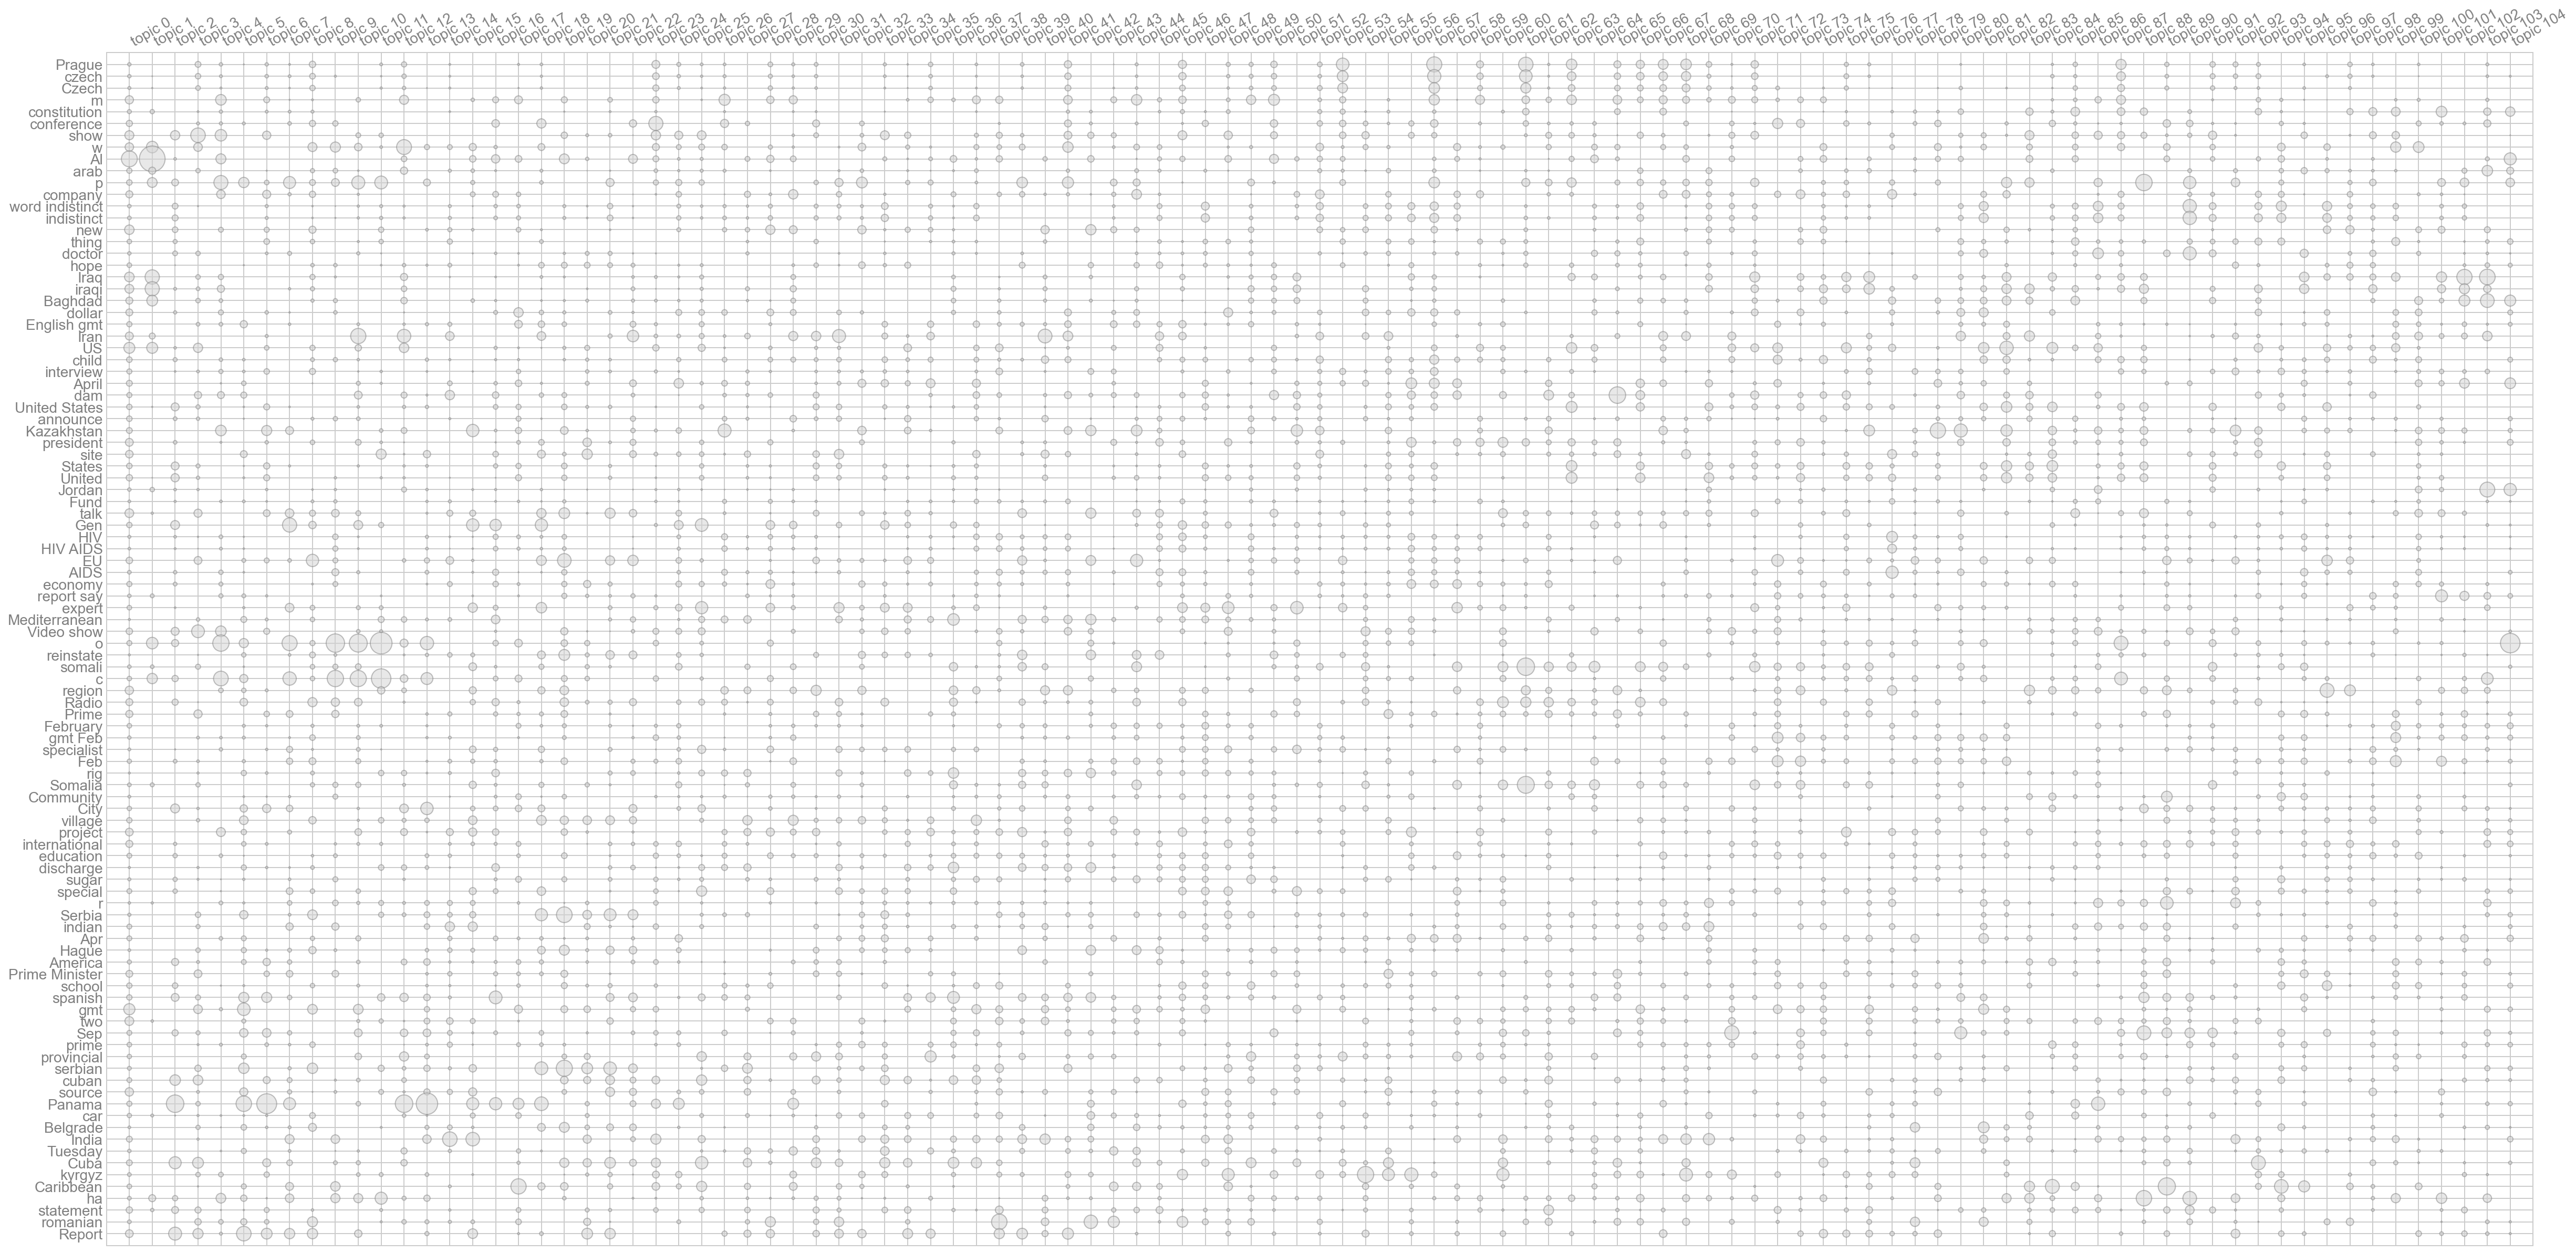

In [9]:
model.termite_plot(
    doc_term_matrix=grp_term_matrix, 
    id2term=vectorizer.id_to_term, 
    topics=-1,  # -1 includes all topics
    n_terms=100,   # number of top terms to be included
    sort_terms_by="seriation",  # ?
    save=os.path.join(figure_dir, 'BBC_2007_07_04_CORPUS_TEXTACY_TM_{}_N{}.{}'.format(model_type.upper(), n_topics, "png")),
    rc_params={"dpi": 300}
)

**Save model**

In [10]:
# persist model to disk
model.save(os.path.join(model_dir, 'BBC_2007_07_04_CORPUS_TEXTACY_TM_{}_N{}.{}'.format(model_type.upper(), n_topics, "pkl")))

INFO:textacy.tm.topic_model:TruncatedSVD(n_components=105, random_state=1) model saved to /Users/felix/ETH/code/nlp4cciwr/models/BBC_2007_07_04_CORPUS_TEXTACY_TM_LSA_N105.pkl
